In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import pylab
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance
from datetime import date

In [2]:
from sklearn import datasets as ds

df = ds.fetch_openml(data_id=151,as_frame=True, return_X_y=True)

# Introdução

O seguinte case tem como objetivo analisar o preço da eletricidade nas cidades australianas de New South Whale e Victoria (referidas como NSW e VIC, respectivamente). Nesse mercado em questão os preços não são fixados, flutuam a cada 5 minutos e são afetados pela oferta e demanda. O dataset a seguir traz essas variações a cada 30 minutos e uma label nos informando se nesse período o preço em NSW subiu (UP) ou desceu (DOWN). 

O intuito é criar um modelo de ML que possa predizer o comportamento do preço (UP/DOWN) e quais variáveis dependentes são as principais influenciadoras nesse comportamento.

## Informações sobre o dataset

**date:** *data entre 8 de maio de 1996 e 5 de dezembro de 1998. Padronizadas entre 0 e 1.*  
**day:** *dia da semana (1-7).*  
**period:** *hora da medição (1-48) a cada 30 minutos em um intervalo de 1 dia (24 horas). Padronizado entre 0 e 1.*  
**nswprice:** *preço da eletricidade em New South Wale. Padronizado entre 0 e 1.*  
**nswdemand:** *demanda da eletricidade em New South Wale. Padronizado entre 0 e 1.*  
**vicprice:** *preço da eletricidade em Victoria. Padronizado entre 0 e 1.*  
**vicdemand:** *demanda da eletricidade em Victoria. Padronizado entre 0 e 1.*   
**transfer:** *transferência agendada de eletricidade entre as duas cidades. Padronizado entre 0 e 1.*  
**class:** *variável categórica. UP: Preço da eletricidade em NSW maior que a média das últimas 24h. Down: caso contrário.*  
**target:** *representação numérica da variável class. 1:UP, 2:DOWN*

[Fonte](https://www.openml.org/search?type=data&sort=runs&status=active&id=151)

In [3]:
df = (

    pd.concat(df, axis=1)

    .assign(target=lambda x: (x['class']=='UP')*1)

)

# Dados

## Tabela dos dados

In [4]:
df.head()

,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class,target
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,UP,1
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,UP,1
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,UP,1
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,UP,1
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,DOWN,0


In [5]:
nswprice = df.nswprice
nswdemand = df.nswdemand
vicprice = df.vicprice
vicdemand = df.vicdemand

## Estrutura dos dados

In [6]:
print(f'Estrutura dos dados: {df.shape}')
print('45312 observações, 10 variáveis.')

# Estatísticas descritivas para cada coluna
print('')
df[['nswprice','nswdemand','vicprice','vicdemand','transfer']].describe()

Estrutura dos dados: (45312, 10)
45312 observações, 10 variáveis.



,nswprice,nswdemand,vicprice,vicdemand,transfer
count,45312.000000,45312.000000,45312.000000,45312.000000,45312.000000
mean,0.057868,0.425418,0.003467,0.422915,0.500526
std,0.039991,0.163323,0.010213,0.120965,0.153373
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.035127,0.309134,0.002277,0.372346,0.414912
50%,0.048652,0.443693,0.003467,0.422915,0.414912
75%,0.074336,0.536001,0.003467,0.469252,0.605702
max,1.000000,1.000000,1.000000,1.000000,1.000000


É possível observar que o preço em NSW é em media 16.69x maior que em VIC, apesar da demanda média ser parecida. Pode-se observar também que a distribuição dos preços em VIC está bem centrada em torno da sua média, o que leva a crer que uma boa estimativa pontual para o preço em VIC seria a própria média amostral.

In [7]:
df.dtypes

date          float64
day          category
period        float64
nswprice      float64
nswdemand     float64
vicprice      float64
vicdemand     float64
transfer      float64
class        category
target          int32
dtype: object

A variável period será transformada em categórica.

In [8]:
df['period'] = df['period'].astype('category')

Verificando se existem valores faltantes:

In [9]:
df.isnull().sum().sum()

0

## Gráficos das Séries

A seguir serão apresentados os gráficos de preço e demanda ao longo do tempo.

Text(0, 0.5, 'Y-axis ')

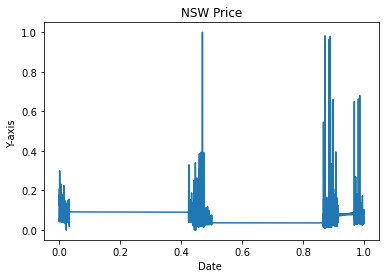

In [10]:
plt.plot(df.date, nswprice)
plt.title("NSW Price")
plt.xlabel('Date ')
plt.ylabel('Y-axis ')

Text(0, 0.5, 'VIC Price')

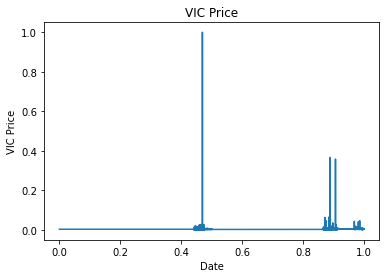

In [11]:
plt.plot(df.date, vicprice)
plt.title("VIC Price")
plt.xlabel('Date')
plt.ylabel('VIC Price')


Text(0, 0.5, 'NSW Demand')

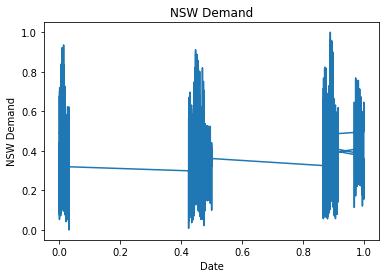

In [12]:
plt.plot(df.date, nswdemand)
plt.title("NSW Demand")
plt.xlabel('Date')
plt.ylabel('NSW Demand')

Text(0, 0.5, 'VIC Demand')

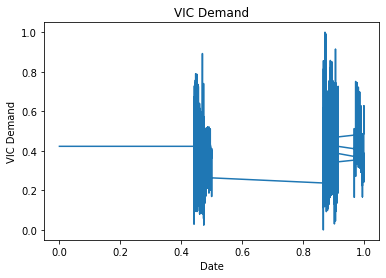

In [13]:
plt.plot(df.date, vicdemand)
plt.title("VIC Demand")
plt.xlabel('Date')
plt.ylabel('VIC Demand')

Em nenhum dos gráficos observou-se tendencia ao longo do tempo.  
Não há homocedasticidade: em NSW houve um aumento expressivo de variabilidade em 4 períodos e em VIC, em 3 períodos (que coincidem com NSW). 

## Matriz de Correlação

In [14]:
df
df2 = df[['nswprice','nswdemand','vicprice','vicdemand','transfer']]

In [15]:
df2.corr()

,nswprice,nswdemand,vicprice,vicdemand,transfer
nswprice,1.000000,0.304952,0.286072,0.307275,-0.275001
nswdemand,0.304952,1.000000,0.086393,0.668501,-0.267897
vicprice,0.286072,0.086393,1.000000,0.127553,-0.084166
vicdemand,0.307275,0.668501,0.127553,1.000000,-0.555525
transfer,-0.275001,-0.267897,-0.084166,-0.555525,1.000000


A única correlação linear forte é entre a demanda em NSW e VIC. A seguir o scatter plot entre as duas variáveis.

Text(0.5, 0, 'NSW')

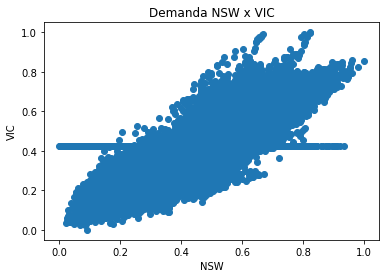

In [16]:
plt.scatter(nswdemand,vicdemand)
plt.title('Demanda NSW x VIC')
plt.ylabel('VIC')
plt.xlabel('NSW')

O gráfico abaixo apresenta a relação entre demanda e preço em NSW, que apesar de não ter uma alta correlação linear, é importante de ser observada. Afinal, segundo a fonte, os preços flutuam de acordo a oferta e demanda.  

Text(0.5, 0, 'Demanda')

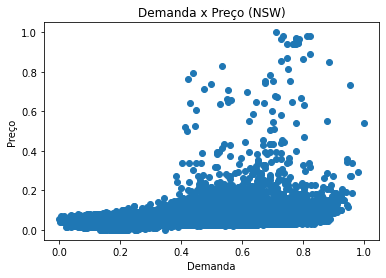

In [17]:
plt.scatter(x=nswdemand,y=nswprice)
plt.title('Demanda x Preço (NSW)')
plt.ylabel('Preço')
plt.xlabel('Demanda')

Preços maiores parecem aparecer apenas para demandas acima de 0.4 e os maiores preços estão ligados a períodos a de alta demanda.
Abaixo gráficos do preço e demanda médios ao longo do tempo.

## Distribuição das variáveis

Abaixo estão apresentados os histogramas das variáveis de preço e demanda em ambas as cidades.

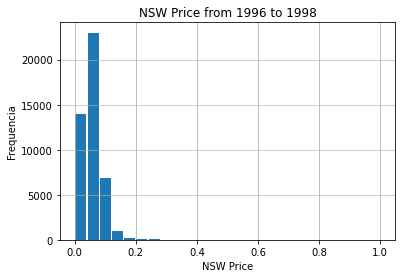

In [18]:
df.nswprice.plot.hist(grid=True,bins=25,rwidth=0.9)
plt.title('NSW Price from 1996 to 1998')
plt.ylabel('Frequencia')
plt.xlabel('NSW Price')
plt.grid(axis='y', alpha=0.75)

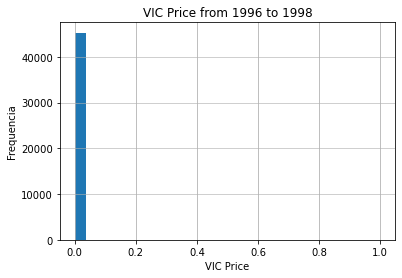

In [19]:
df.vicprice.plot.hist(grid=True,bins=25,rwidth=0.9)
plt.title('VIC Price from 1996 to 1998')
plt.ylabel('Frequencia')
plt.xlabel('VIC Price')
plt.grid(axis='y', alpha=0.75)


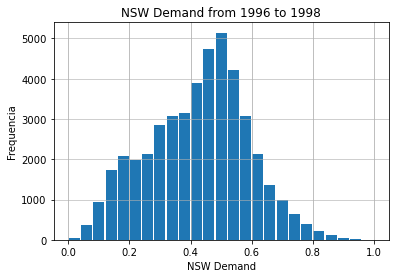

In [20]:
df.nswdemand.plot.hist(grid=True,bins=25,rwidth=0.9)
plt.title('NSW Demand from 1996 to 1998')
plt.ylabel('Frequencia')
plt.xlabel('NSW Demand')
plt.grid(axis='y', alpha=0.75)
plt.show()

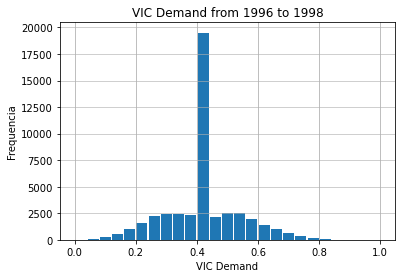

In [21]:
df.vicdemand.plot.hist(grid=True,bins=25,rwidth=0.9)
plt.title('VIC Demand from 1996 to 1998')
plt.ylabel('Frequencia')
plt.xlabel('VIC Demand')
plt.grid(axis='y', alpha=0.75)

Os três gráficos a seguir exibem a distribuição das variáveis nswprice, nswdemand e vicdemand a cada dia da semana. No primeiro gráfico observa-se que a variável nswprice apresenta forte assimetria positiva em todos os dias, sendo que a maior parte dos dados está concentrada em valores próximos de zero. Esse comportamento se repete de modo similar nos sete dias da semana. Isso não quer dizer que os preços sejam baixos, afinal as variáveis foram padronizadas entre 0 e 1, apenas indica que existem poucos valores muito acima do padrão.

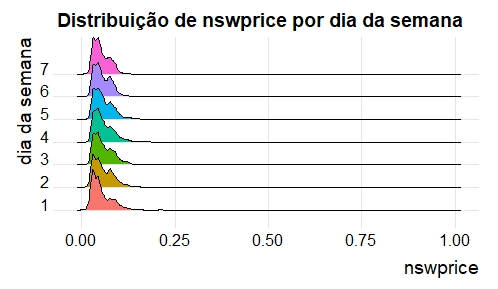

Já no gráfico de nswdemand mostrado abaixo, percebe-se que a distribuição dessa variável muda ao longo dos dias da semana. Nos dias 6, 7 e 1 percebe-se uma distribuição mais simétrica, com leve assimetria positiva, enquanto nos demais dias, o pico da distribuição ocorre em valores mais altos. 

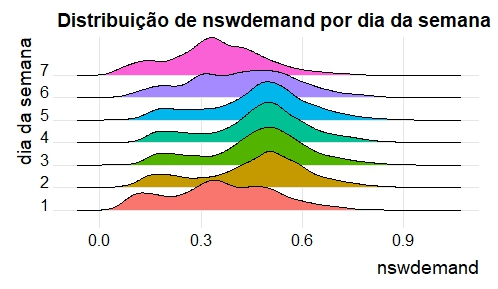

A distribuição de vicdemand apresenta picos (modas) muito similares ao longo dos dias da semana. No entanto, nos dias 7 e 1, a distribuição possui uma maior concentração na cauda esquerda do que os demais dias, ou seja, a demanda tende a ser menor nos finais de semana (sábado e domingo).

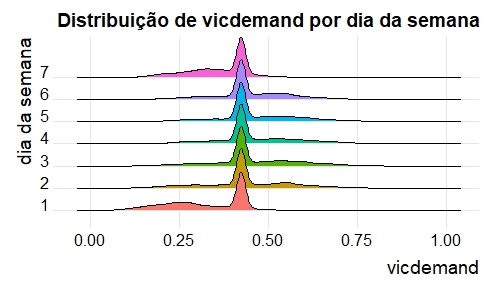

A seguir estão apresentados os boxplots das variáveis nswdemand e vicdemand por período do dia. Por meio do gráfico de nswdemand, percebe-se uma forte sazonalidade decorrente do período do dia, onde os valores apresentam um forte declínio nas primeiras horas do dia, atingindo o seu mínimo por volta do $8^o$ período (04 AM), seguido de um aumento constante até o $18^o$ período (09 AM), quando o valor se estabiliza. Um novo, porém mais leve declínio acontece por volta do $38^o$ período do dia (07 PM), mas se estabiliza rapidamente. Comportamento similar observa-se no gráfico de vicdemand.

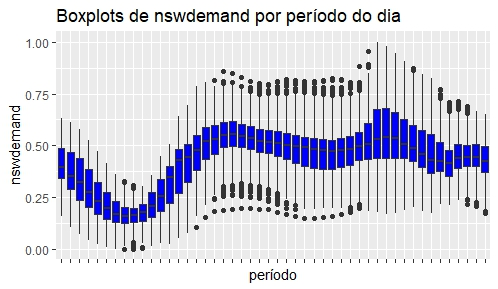

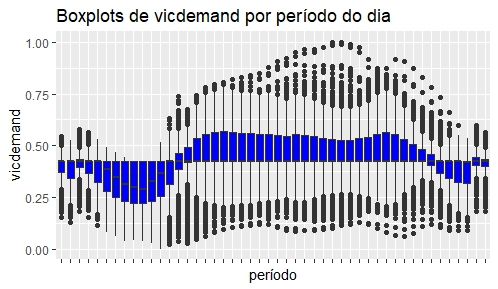

Dos gráficos a seguir é possível extrair a informação de que a distribuição de nswdemand assume valores menores para os indíviduos classificados como DOWN, ou seja, quando a demanda é menor, os preços tendem a baixar. O que nos leva a crer que nswdemand será uma variável significativa para o modelo, o que vai de acordo com o esperado. Comportamento semalhante em Victória.

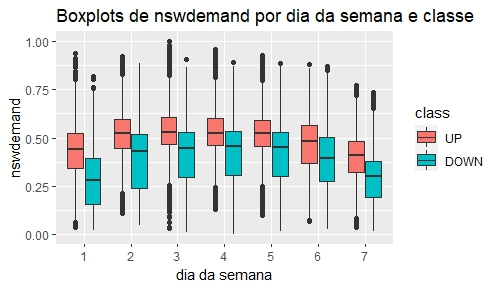

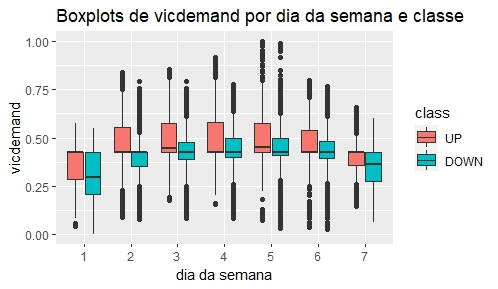

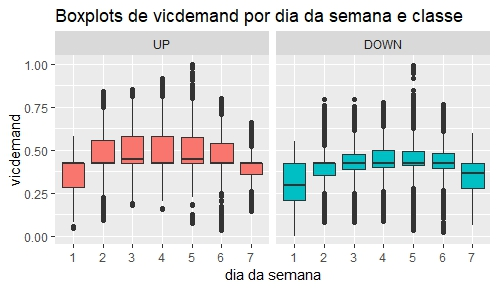

Abaixo estão apresentados os gráficos de dispersão entre as demandas e a transferencia agendada de energia entre as cidades. É possível observar correlação negativa entre as variáveis, e, como já foi observado, alta demanda gera aumento nos preços (UP). Não parece haver relação de transfer com o aumento/diminuição dos preços em NSW.

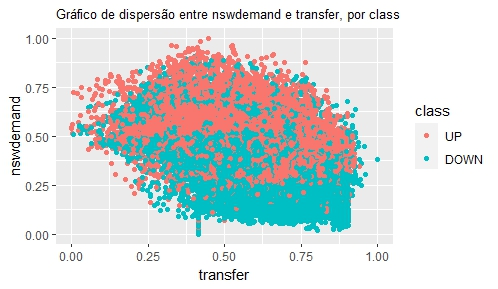

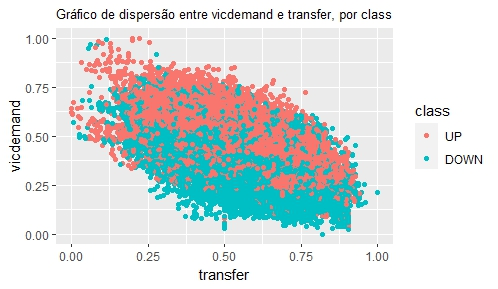

# Classificação através de modelos de Machine Learning

Divindo os dados em amostras de teste e treino. E selecionando as variáveis que serão utilizadas no modelo.

Foram retiradas as variáveis date e nswprice.  
Date foi retirada por que o modelo utilizado não terá uma abordagem de série temporal (para isso utilizaria-se modelos de séries temporais, sendo que o objetivo deste trabalho é fazer classificações).  
Nswprice foi retirada por ter sido utilizada para calcular a classe.

In [48]:
X = df.drop(["date","nswprice","class","target"],axis=1)
X = X.values
y = df[['target']]
y = y.values
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

A seguir estão apresentados 3 modelos. Esses modelos foram obtidos de forma sequencial na busca de um melhor modelo classificador. Partiu-se de modelos mais simples para mais complexos, até se obter um resultado satisfatório.

## Regressão Logística

In [23]:
log_regression = LogisticRegression()
log_regression.fit(X_train,y_train.ravel())

LogisticRegression()

In [24]:
y_pred = log_regression.predict(X_test)

# Accuracy
accuracy_score(y_test, y_pred)

0.6474915403854642

In [25]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.74      0.71      7873
           1       0.59      0.52      0.55      5721

    accuracy                           0.65     13594
   macro avg       0.64      0.63      0.63     13594
weighted avg       0.64      0.65      0.64     13594



### Curva ROC

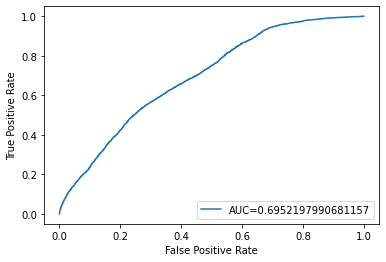

In [26]:
y_pred_proba = log_regression.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Resultados não foram satisfatórios, baixa acurácia e AUC abaixo do aceitável (<0.7). 

A seguir uma tentativa de ajuste com o algoritmo KNN.

## K Nearest Neighbors (KNN)

Utilizou-se o algoritmo GridSearchCV para procurar o melhor valor para k (testou-se valores de 1 a 50). 

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train.ravel())
gridsearch.best_params_

{'n_neighbors': 13}

In [50]:
y_pred_grid = gridsearch.predict(X_test)

print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      7873
           1       0.67      0.65      0.66      5721

    accuracy                           0.72     13594
   macro avg       0.71      0.71      0.71     13594
weighted avg       0.72      0.72      0.72     13594



É possível perceber significativa melhora na acurácia entre os modelos de regressão logística e KNN, de 0.65 para 0.72. E também no f1-score, para ambas as classificações.

Adicionando peso às distancias e verificando se existe uma melhora no modelo (é necessário verificar novamente o melhor número para k, pois não necessariamente será o mesmo).

In [32]:
parameters = {
    "n_neighbors": range(1, 15),
    "weights": ["uniform", "distance"],
}

gridsearch2 = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch2.fit(X_train, y_train.ravel())

gridsearch2.best_params_

{'n_neighbors': 13, 'weights': 'uniform'}

In [33]:
y_pred_grid2 = gridsearch2.predict(X_test)

print(classification_report(y_test, y_pred_grid2))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76      7873
           1       0.67      0.65      0.66      5721

    accuracy                           0.72     13594
   macro avg       0.71      0.71      0.71     13594
weighted avg       0.72      0.72      0.72     13594



Aparentemente não houve melhora do modelo ao adicionar peso as distancias (todas as medidas se mantiveram).

### Curva ROC

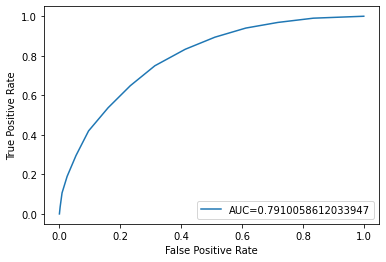

In [34]:
y_pred_proba = gridsearch.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

As medidas são aceitáveis, porém não são excelentes.  
Decidiu-se seguir a análise com um novo algoritmo e ver se é possível obter um melhor modelo de classificação.

## Random Forest

A seguir estão apresentados os resultados de um Random Forest instanciado com 900 arvores (foram feitos testes até se chegar nesse valor). 

In [35]:
# Importando o modelo
from sklearn.ensemble import RandomForestClassifier

# Instanciando modelo com 900 arvores
rf = RandomForestClassifier(n_estimators = 900, random_state = 0)

# Treinando o modelo nas amostras de treino
rf.fit(X_train, y_train.ravel())

RandomForestClassifier(n_estimators=900, random_state=0)

In [36]:
# Predição na amostra de teste
y_pred = rf.predict(X_test)

#Report de Acurácia
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80      7873
           1       0.73      0.70      0.71      5721

    accuracy                           0.76     13594
   macro avg       0.76      0.76      0.76     13594
weighted avg       0.76      0.76      0.76     13594



Melhora significativa na predição em relação aos modelos anteriores (em todas as medidas de acurácia).

### Matriz de Confusão

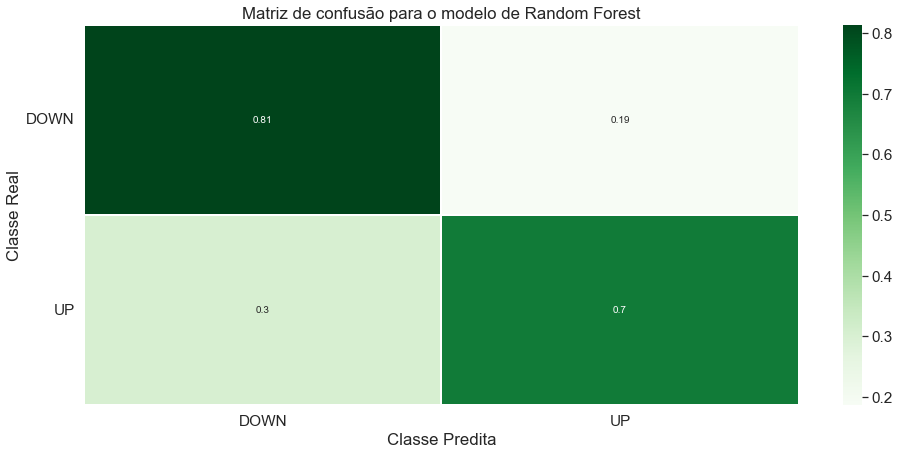

In [37]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

class_names = ['DOWN', 'UP']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Classe Predita')
plt.ylabel('Classe Real')
plt.title('Matriz de confusão para o modelo de Random Forest')
plt.show()

81% de acerto para classe DOWN.  
70% para classe UP.

### Curva ROC

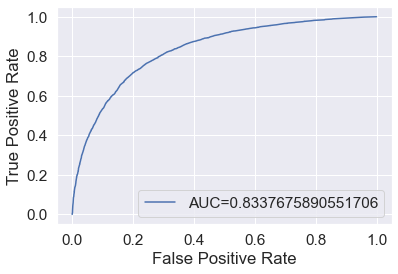

In [38]:
y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Segundo a literatura, um AUC (área abaixo da curva ROC) entre 0.8 e 0.9 é considerado excelente.  
(Hosmer and Lemeshow em [Applied Logistic Regression, p. 177](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118548387))

O trabalho seguiu com tentativas de melhorar o modelo.

Chegou-se ao modelo final com os seguintes hiperparâmetros:  
**Nº de árvores:** 900    
**Nº máximo de atributos em cada árvore:** 5  
**Critério do split:** entropia

In [39]:
# Instantiate model with 900 decision trees
rf = RandomForestClassifier(n_estimators = 900, random_state = 0, criterion='entropy', max_features = 5 ) 

# Train the model on training data
rf.fit(X_train, y_train.ravel())

RandomForestClassifier(criterion='entropy', max_features=5, n_estimators=900,
                       random_state=0)

In [40]:
# Predição
y_pred = rf.predict(X_test)

# Report de Acurácia
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.80      7873
           1       0.74      0.70      0.72      5721

    accuracy                           0.77     13594
   macro avg       0.76      0.76      0.76     13594
weighted avg       0.77      0.77      0.77     13594



Aumento no f1-score para classe UP e aumento na acurácia, ambos de aproximadamente 1 ponto percentual.

### Importância dos atributos no modelo

A demanda em NSW foi o atributo mais importante para o modelo (Gini importance, baseado na impureza dos atributos), com o valor de 38,33%.  
Seguido por preço da energia em Victoria (18,76%), período do dia (15,22%), demanda em Victoria (10,18%), datas agendadas para transferência de energia entre as duas cidades (9.48%) e dia da semana (8.03%).

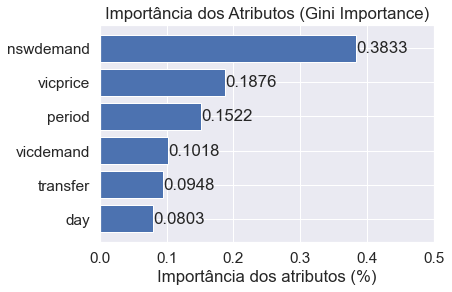

In [42]:
headers = ['day','period','nswdemand','vicprice','vicdemand','transfer']
headers = np.array(headers)
fig,ax = plt.subplots()
sorted_idx = rf.feature_importances_.argsort()
hbars = ax.barh(headers[sorted_idx], rf.feature_importances_[sorted_idx],align='center')
ax.set_xlabel('Importância dos atributos (%)')
ax.set_title('Importância dos Atributos (Gini Importance)')

ax.bar_label(hbars, fmt='%.4f')
ax.set_xlim(right=0.5) 

plt.show()

Essa medida pode inflar a importância dos atributos numéricos. Outro ponto é que por ser calculada em estatísticas derivadas do conjunto de dados de sua formação, as importâncias podem ser elevadas mesmo que não contribuam tanto para as predições, desde que contribuam para o ajuste do modelo.

Para mitigar esses problemas será utilizado o "Permutation Importances", que permuta os valores de atributo por atributo e mede quais causam maiores perdas na acurácia do modelo. 

In [43]:
perm_importance = permutation_importance(rf, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()

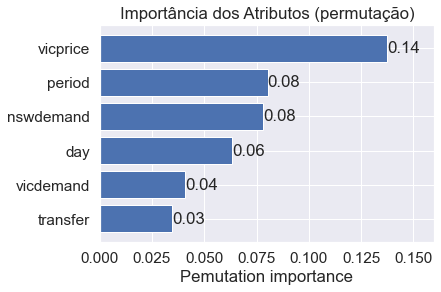

In [44]:
fig,ax = plt.subplots()
hbars = ax.barh(headers[sorted_idx], perm_importance.importances_mean[sorted_idx],align='center')
ax.set_xlabel('Pemutation importance')
ax.set_title('Importância dos Atributos (permutação)')

ax.bar_label(hbars, fmt='%.2f')
ax.set_xlim(right=0.16) 

plt.show()

É possível observar que ambas as variáveis categóricas (day e period) agora apresentam maior importância (quando comparadas a sua importância medida pela impureza dos atributos). O preço da energia em Victória aparece como a variável com maior importância, seguida pelas variáveis: period, nswdemand, day, vicdemand e transfer.

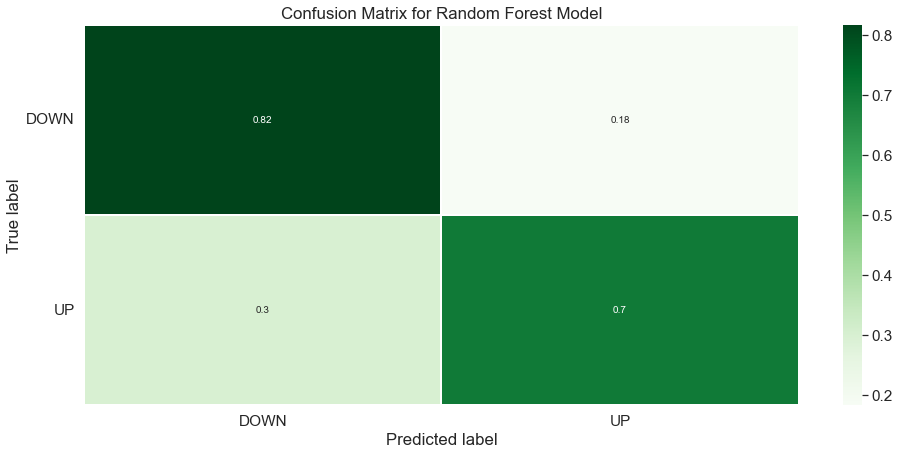

In [45]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

class_names = ['DOWN', 'UP']
tick_marks = np.arange(len(class_names)) + 0.5
tick_marks2 = tick_marks
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

Percebe-se melhora na predição da classe DOWN, de 0.81 para 0.82.

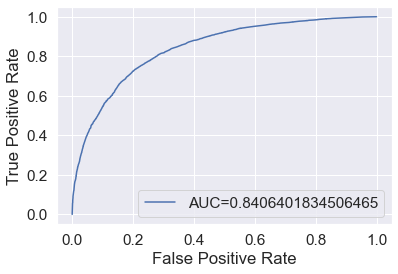

In [47]:
y_pred_proba = rf.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Melhora de aproximamente 0.01. Resultado tido como satisfatório.

# Conclusão

Após testar alguns modelos de ML chegou-se a um resultado satisfatório através do algoritmo Random Forest. Um próximo passo seria testar algoritmos mais complexos como xgboost e lighgbm, ambos também baseados em arvore de decisão, porém com uma estrutura de aumento de gradiente (gradient boosting).

As variáveis que representavam o periodo do dia, demanda em New South Wale e preço da eletricidade em Victoria foram as que apresentaram maior importância no modelo de classificação. 

O modelo final apresentou:  
Acurácia de 0.77,  
F1_score de 0.80 e 0.72 para as classes DOWN e UP, respectivamente,  
AUC 0.84, considerado excelente pela literatura. (Hosmer and Lemeshow em [Applied Logistic Regression, p. 177](https://onlinelibrary.wiley.com/doi/book/10.1002/9781118548387)).